In [6]:
!pip install seaborn
!pip install seaborn --upgrade

In [24]:
# Importacion de librerias
from typing import Tuple, Dict, Any
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_squared_error, r2_score
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.impute import SimpleImputer

In [32]:
# Crear Clase para analisis de precio de vehiculo
class CarPriceAnalysis:
    def __init__(self):
        self.data = None
        self.X = None
        self.y = None
        self.y_binary = None
        self.required_features = [
            'Car_Name', 'Selling_Price', 'Fuel_Type',
            'Transmission', 'Seller_Type'
        ]

    def load_data(self) -> None:
        """Carga y combina los datasets de automóviles"""
        datasets = []
        dataset_path = "./Dataset Vehicle/"
        for file in [
            'car data.csv',
            'CAR DETAILS FROM CAR DEKHO.csv',
            'Car details v3.csv',
            'car details v4.csv'
        ]:
            try:
                df = pd.read_csv(f"{dataset_path}{file}")
                datasets.append(df)
            except Exception as e:
                print(f"Error al cargar {file}: {str(e)}")

        if not datasets:
            raise ValueError("No se pudo cargar ningún dataset")

        self.data = pd.concat(datasets, ignore_index=True)

    def perform_eda(self) -> None:
        """Realiza análisis exploratorio de datos"""
        if self.data is None:
            raise ValueError("Datos no cargados. Ejecute load_data() primero.")

        print("=== Análisis Exploratorio de Datos ===")
        print("\nEstadísticas descriptivas:")
        print(self.data.describe())

        # Visualización básica
        plt.style.use('seaborn-v0_8')
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Distribución de precios
        self.data['Selling_Price'].hist(ax=ax1, bins=30)
        ax1.set_title('Distribución de Precios')
        ax1.set_xlabel('Precio')
        ax1.set_ylabel('Frecuencia')

        # Relación año vs precio
        ax2.scatter(self.data['Year'], self.data['Selling_Price'], alpha=0.5)
        ax2.set_title('Año vs Precio')
        ax2.set_xlabel('Año')
        ax2.set_ylabel('Precio')

        plt.tight_layout()
        plt.show()

    def preprocess_data(self) -> None:
        """Alistar los datos para el modelado"""
        if self.data is None:
            raise ValueError("Datos no cargados. Ejecute load_data() primero.")

        # Verificar columnas requeridas
        missing_cols = set(self.required_features) - set(self.data.columns)
        if missing_cols:
            raise ValueError(f"Columnas faltantes: {missing_cols}")

        # Eliminar columnas completamente vacías
        self.data = self.data.dropna(axis=1, how='all')

        # Separar columnas numéricas y categóricas
        numeric_cols = self.data.select_dtypes(include=['float64', 'int64']).columns
        categorical_cols = self.data.select_dtypes(include=['object']).columns

        print("=== Tipos de Datos ===")
        print(self.data.dtypes)

        # Convertir las columnas categóricas a 'string'
        for col in categorical_cols:
            self.data[col] = self.data[col].astype(str)

        # Eliminación de valores faltantes para columnas categóricas (estrategia 'most_frequent')
        imputer_categorical = SimpleImputer(strategy='most_frequent')
        self.data[categorical_cols] = imputer_categorical.fit_transform(self.data[categorical_cols])

        # Convertir columnas categóricas a valores numéricos
        le = LabelEncoder()
        for col in categorical_cols:
            self.data[col] = le.fit_transform(self.data[col])

        # Eliminación de valores faltantes para columnas numéricas (estrategia 'mean')
        imputer_numeric = SimpleImputer(strategy='mean')
        self.data[numeric_cols] = imputer_numeric.fit_transform(self.data[numeric_cols])

        # Mostrar las primeras filas del DataFrame después de la Eliminación
        print("=== Datos después de la imputación ===")
        print(self.data.head())

        # Preparación de características
        self.X = self.data.drop(['Car_Name', 'Selling_Price'], axis=1)
        self.y = self.data['Selling_Price']
        self.y_binary = (self.y > self.y.median()).astype(int)

    def train_models(self) -> Dict[str, Any]:
        """Entrena y evalúa los modelos"""
        if self.X is None or self.y is None:
            raise ValueError("Datos no preparados. Ejecute preprocess_data() primero.")

        # Eliminación y selección de características
        imputer = SimpleImputer(strategy='mean')
        X_imputed = imputer.fit_transform(self.X)

        selector = SelectKBest(f_regression, k=5)
        X_selected = selector.fit_transform(X_imputed, self.y)

        # División de datos en Train y Test
        X_train, X_test, y_train, y_test = train_test_split(
            X_selected, self.y, test_size=0.2, random_state=42
        )

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Entrenamiento y evaluación
        models = {}

        # Modelo de Regresión Lineal
        lin_reg = LinearRegression()
        lin_reg.fit(X_train_scaled, y_train)
        y_pred_lin = lin_reg.predict(X_test_scaled)

        models['linear'] = {
            'model': lin_reg,
            'predictions': y_pred_lin,
            'metrics': {
                'mse': mean_squared_error(y_test, y_pred_lin),
                'r2': r2_score(y_test, y_pred_lin)
            }
        }

        return models, y_test

    def visualize_results(self, models: Dict[str, Any], y_test: np.ndarray) -> None:
        """Visualiza los resultados de los modelos"""
        plt.figure(figsize=(15, 5))

        # Comparación de predicciones
        for i, (name, model_info) in enumerate(models.items(), 1):
            plt.subplot(1, 2, i)
            plt.scatter(y_test, model_info['predictions'], alpha=0.5)
            plt.plot([y_test.min(), y_test.max()],
                    [y_test.min(), y_test.max()],
                    'r--', lw=2)
            plt.title(f'Predicciones vs Reales - {name.capitalize()}')
            plt.xlabel('Valores Reales')
            plt.ylabel('Predicciones')

        plt.tight_layout()
        plt.show()

=== Análisis Exploratorio de Datos ===

Estadísticas descriptivas:
              Year  Selling_Price  Present_Price     Kms_Driven          year  \
count  2360.000000     301.000000     301.000000     301.000000  12468.000000   
mean   2016.068644       4.661296       7.628472   36947.205980   2013.555743   
std       3.435772       5.082812       8.644115   38886.883882      4.118485   
min    1988.000000       0.100000       0.320000     500.000000   1983.000000   
25%    2014.000000       0.900000       1.200000   15000.000000   2011.000000   
50%    2016.000000       3.600000       6.400000   32000.000000   2014.000000   
75%    2018.000000       6.000000       9.900000   48767.000000   2017.000000   
max    2022.000000      35.000000      92.600000  500000.000000   2020.000000   

       selling_price     km_driven        seats         Price     Kilometer  \
count   1.246800e+04  1.246800e+04  7907.000000  2.059000e+03  2.059000e+03   
mean    5.915773e+05  6.856508e+04     5.4167

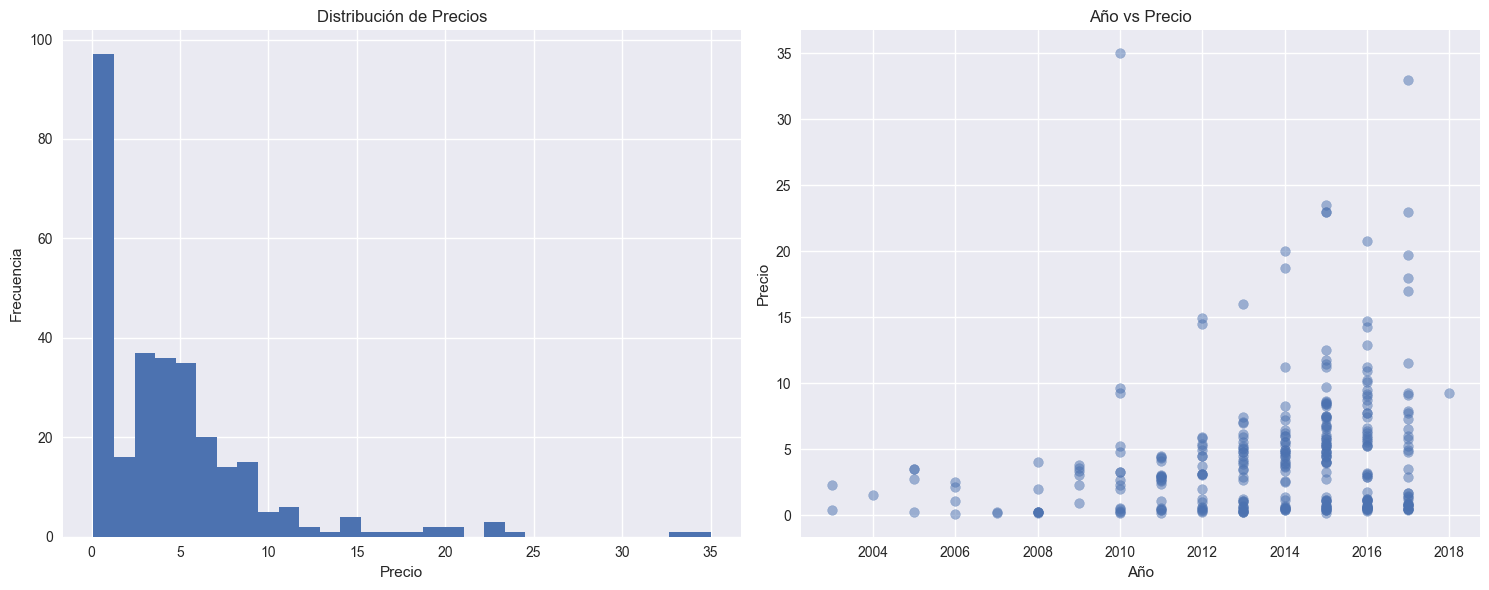

=== Tipos de Datos ===
Car_Name               object
Year                  float64
Selling_Price         float64
Present_Price         float64
Kms_Driven            float64
Fuel_Type              object
Seller_Type            object
Transmission           object
Owner                  object
name                   object
year                  float64
selling_price         float64
km_driven             float64
fuel                   object
seller_type            object
transmission           object
owner                  object
mileage                object
engine                 object
max_power              object
torque                 object
seats                 float64
Make                   object
Model                  object
Price                 float64
Kilometer             float64
Fuel Type              object
Location               object
Color                  object
Seller Type            object
Engine                 object
Max Power              object
Max Torque       

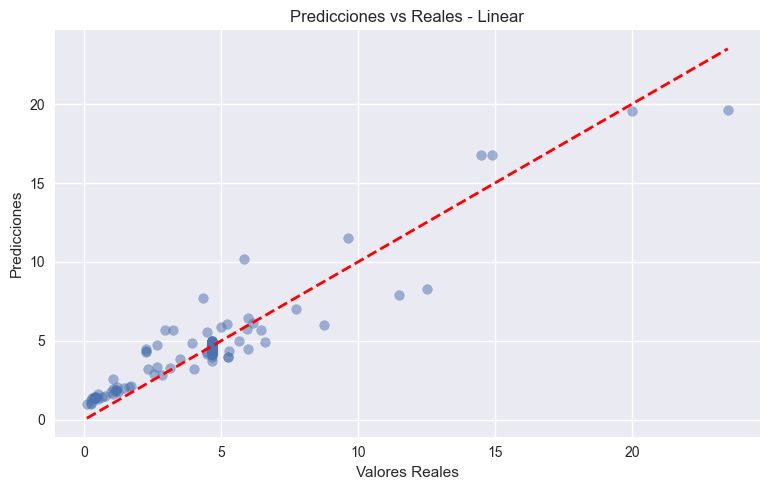

In [34]:
# Ejecutar funcion para analisis de Año vs Precio
def main():
    """Función principal para ejecutar el análisis"""
    try:
        # Inicialización y carga de datos
        analyzer = CarPriceAnalysis()
        analyzer.load_data()

        # Análisis exploratorio
        analyzer.perform_eda()

        # Preprocesamiento
        analyzer.preprocess_data()

        # Entrenamiento y evaluación
        models, y_test = analyzer.train_models()

        # Resultados
        print("\n=== Resultados de los Modelos ===")
        for name, model_info in models.items():
            print(f"\nModelo: {name.capitalize()}")
            for metric_name, value in model_info['metrics'].items():
                print(f"{metric_name}: {value:.4f}")

        # Visualizaciones
        analyzer.visualize_results(models, y_test)

    except Exception as e:
        print(f"Error en la ejecución: {str(e)}")

if __name__ == "__main__":
    main()